In [9]:
library(ALDEx2)
library(ggplot2)
library(reshape2)
library(dada2)
library(patchwork)
library(phyloseq)
library(MASS)
library(fitdistrplus)


Loading required package: zCompositions

Warning message:
"package 'zCompositions' was built under R version 4.3.3"
Loading required package: MASS

Loading required package: NADA

Warning message:
"package 'NADA' was built under R version 4.3.3"
Loading required package: survival


Attaching package: 'NADA'


The following object is masked from 'package:stats':

    cor


Loading required package: truncnorm

Warning message:
"package 'truncnorm' was built under R version 4.3.3"
Loading required package: lattice

Warning message:
"package 'lattice' was built under R version 4.3.3"
Loading required package: latticeExtra

Warning message:
"package 'latticeExtra' was built under R version 4.3.3"

Attaching package: 'ggplot2'


The following object is masked from 'package:latticeExtra':

    layer


Warning message:
"package 'reshape2' was built under R version 4.3.3"
Loading required package: Rcpp

Warning message:
"package 'Rcpp' was built under R version 4.3.3"
Warning message:
"package 

In [1]:
taxa_hetero1<- readRDS("taxa_silva_hetero1.rds")
taxa_oc1<- readRDS("taxa_silva_oc1.rds")
phylo_hetero1<- readRDS("phyloseq_object_hetero1.rds")
phylo_oc1<- readRDS("phyloseq_object_oc_phase1.rds")
hetero1<- as.data.frame(phylo_hetero1@otu_table)
oc1<- as.data.frame(phylo_oc1@otu_table)
taxa_od_wgs<- read.table("merged_absolute_abundance_od1.tsv", sep = "\t", header = T, row.names = 1)
taxa_oc_wgs<- read.table("merged_absolute_abundance_oc1.tsv", sep = "\t", header = T, row.names = 1)
seqtab.nochim_oc<- readRDS("seqtab.nochim_oc.rds")
seqtab.nochim_hetero<- readRDS("seqtab.nochim_hetero.rds")

Loading required package: phyloseq



In [2]:
generate_taxa_labels <- function(otu_table_df, tax_table_df, 
                                 rank_prefixes = c("K", "P", "C", "O", "F", "G")) {
  # Replace NAs in taxonomy with 'unclassified'
  tax_table_df[is.na(tax_table_df)] <- "unclassified"
  
  # Construct taxonomic labels
  tax_labels <- apply(tax_table_df, 1, function(row) {
    paste(paste0(rank_prefixes, ":_", row), collapse = "|")
  })
  
  # Assign new column names to the OTU table
  if (nrow(tax_table_df) != ncol(otu_table_df)) {
    stop("Mismatch between number of taxa and OTU table columns")
  }
  
  colnames(otu_table_df) <- tax_labels
  return(otu_table_df)
}


In [3]:
ps_oc <- phyloseq(otu_table(seqtab.nochim_oc, taxa_are_rows=FALSE), 
               tax_table(taxa_oc1))
ps_hetero <- phyloseq(otu_table(seqtab.nochim_hetero, taxa_are_rows=FALSE), 
               tax_table(taxa_hetero1))

dna_oc <- Biostrings::DNAStringSet(taxa_names(ps_oc))
names(dna_oc) <- taxa_names(ps_oc)
ps_oc <- merge_phyloseq(ps_oc, dna_oc)
taxa_names(ps_oc) <- paste0("ASV", seq(ntaxa(ps_oc)))
ps_oc

dna_hetero<- Biostrings::DNAStringSet(taxa_names(ps_hetero))
names(dna_hetero) <- taxa_names(ps_hetero)
ps_hetero <- merge_phyloseq(ps_hetero, dna_hetero)
taxa_names(ps_hetero) <- paste0("ASV", seq(ntaxa(ps_hetero)))
ps_hetero

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2139 taxa and 21 samples ]
tax_table()   Taxonomy Table:    [ 2139 taxa by 6 taxonomic ranks ]
refseq()      DNAStringSet:      [ 2139 reference sequences ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6565 taxa and 21 samples ]
tax_table()   Taxonomy Table:    [ 6565 taxa by 6 taxonomic ranks ]
refseq()      DNAStringSet:      [ 6565 reference sequences ]

In [4]:
make_taxonomy_abundance_df <- function(ps, rank_prefixes = c("K", "P", "C", "O", "F", "G")) {
  otu_df  <- as.data.frame(otu_table(ps))
  tax_df  <- as.data.frame(tax_table(ps))
  
  if (taxa_are_rows(ps)) {
    otu_df <- t(otu_df)
  }

  # Ensure shared and matched taxa by name
  shared_taxa <- intersect(colnames(otu_df), rownames(tax_df))
  
  if (length(shared_taxa) == 0) {
    stop("❌ No overlapping taxa between OTU table and taxonomy table.")
  }

  otu_df <- otu_df[, shared_taxa, drop = FALSE]
  tax_df <- tax_df[shared_taxa, , drop = FALSE]
  
  # Replace NAs in taxonomy
  tax_df[is.na(tax_df)] <- "unclassified"
  
  # Create labeled taxonomic strings
  tax_labels <- apply(tax_df, 1, function(row) {
    paste(paste0(rank_prefixes, ":_", row), collapse = "|")
  })
  
  # Assign labels as column names
  colnames(otu_df) <- tax_labels
  return(as.data.frame(otu_df))
}

In [5]:
tax_abund_oc     <-t(make_taxonomy_abundance_df(ps_oc))
tax_abund_hetero <- t(make_taxonomy_abundance_df(ps_hetero))

# Filtration of taxa 

In [ ]:
filter_low_abundance <- function(df, min_count = 5, min_prevalence = 0.1) {
  n_samples <- ncol(df)
  prevalence <- rowSums(df > min_count) / n_samples
  filtered_df <- df[prevalence >= min_prevalence, ]
  message("Filtered: ", nrow(df) - nrow(filtered_df), " features removed")
  return(filtered_df)
}

In [7]:
taxa_od_wgs_filtered          <- filter_low_abundance(taxa_od_wgs)
taxa_oc_wgs_filtered          <- filter_low_abundance(taxa_oc_wgs)
tax_abund_oc_filtered         <- filter_low_abundance(tax_abund_oc)
tax_abund_hetero_filtered     <- filter_low_abundance(tax_abund_hetero)

Filtered: 489 features removed

Filtered: 1 features removed

Filtered: 1676 features removed

Filtered: 6549 features removed



In [ ]:
run_aldex_normalization <- function(abundance, cond_label, seed = 42) {
  set.seed(seed)
  
  # Replace NA with 0
  abundance[is.na(abundance)] <- 0
  
  # Remove zero-sum rows and record original IDs
  row_sums <- rowSums(abundance)
  abundance <- abundance[row_sums > 0, , drop = FALSE]
  
  # Ensure unique column names
  if (any(duplicated(colnames(abundance)))) {
    warning("Duplicate sample names found. Making them unique.")
    colnames(abundance) <- make.unique(colnames(abundance))
  }

  conds <- rep("heterogenic", ncol(abundance))
  
  # Run ALDEx2
  aldex_clr <- aldex.clr(abundance, conds = conds, mc.samples = 128, denom = "all", verbose = TRUE)
  
  # Extract MC samples
  clr_list <- aldex_clr@analysisData
  
  # Average across MC replicates
  clr_avg <- lapply(clr_list, function(mat) rowMeans(mat))
  
  # Combine into matrix
  clr_matrix <- do.call(cbind, clr_avg)
  
  # Safe assignment of names
  colnames(clr_matrix) <- colnames(abundance)
  rownames(clr_matrix) <- rownames(abundance)
  
  return(clr_matrix)
}
clr_od_wgs_filtered <- run_aldex_normalization(taxa_od_wgs_filtered, "ocean_deep_filtered")
clr_oc_wgs_filtered <- run_aldex_normalization(taxa_oc_wgs_filtered, "ocean_coastal_filtered")
clr_oc_amp_filtered <- run_aldex_normalization(tax_abund_oc_filtered, "ocean_coastal_amp_filtered")
clr_hetero_amp_filtered <- run_aldex_normalization(tax_abund_hetero_filtered, "hetero_amp_filtered")




conditions vector supplied

operating in serial mode

removed rows with sums equal to zero

computing center with all features

data format is OK

dirichlet samples complete

transformation complete

conditions vector supplied

operating in serial mode

removed rows with sums equal to zero

computing center with all features

data format is OK

dirichlet samples complete

transformation complete

conditions vector supplied

operating in serial mode

removed rows with sums equal to zero

computing center with all features

data format is OK

dirichlet samples complete

transformation complete

conditions vector supplied

operating in serial mode

removed rows with sums equal to zero

computing center with all features

data format is OK

dirichlet samples complete

transformation complete



Running ALDEx2 CLR on: ocean_deep

conditions vector supplied

operating in serial mode

removed rows with sums equal to zero

computing center with all features

data format is OK

dirichlet samples complete

transformation complete

Warning message in xy.coords(x, y, xlabel, ylabel, log):
"491 x values <= 0 omitted from logarithmic plot"


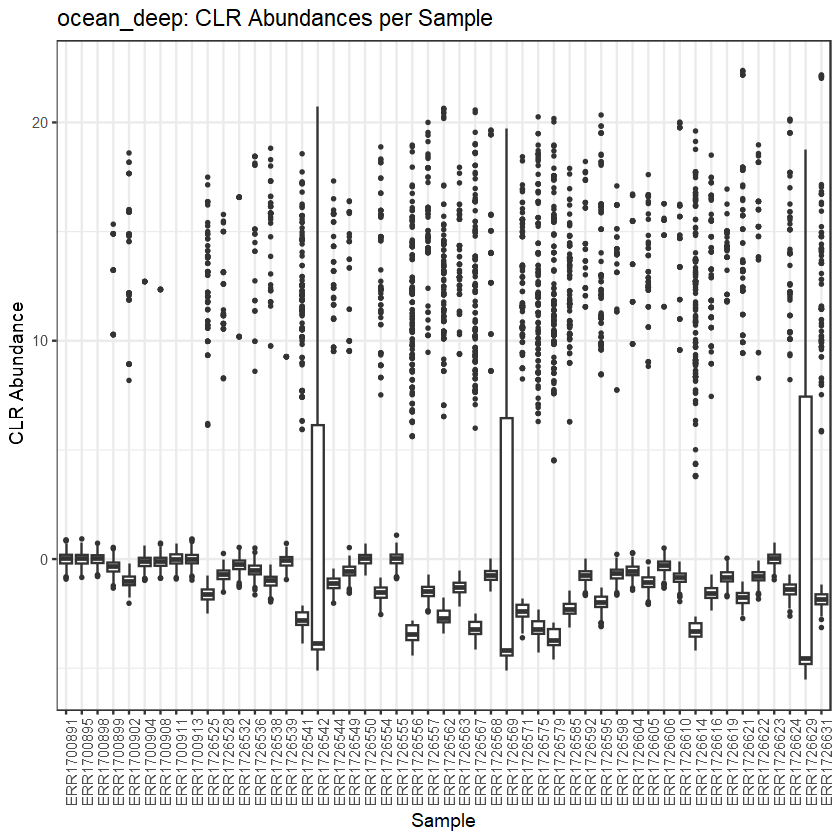

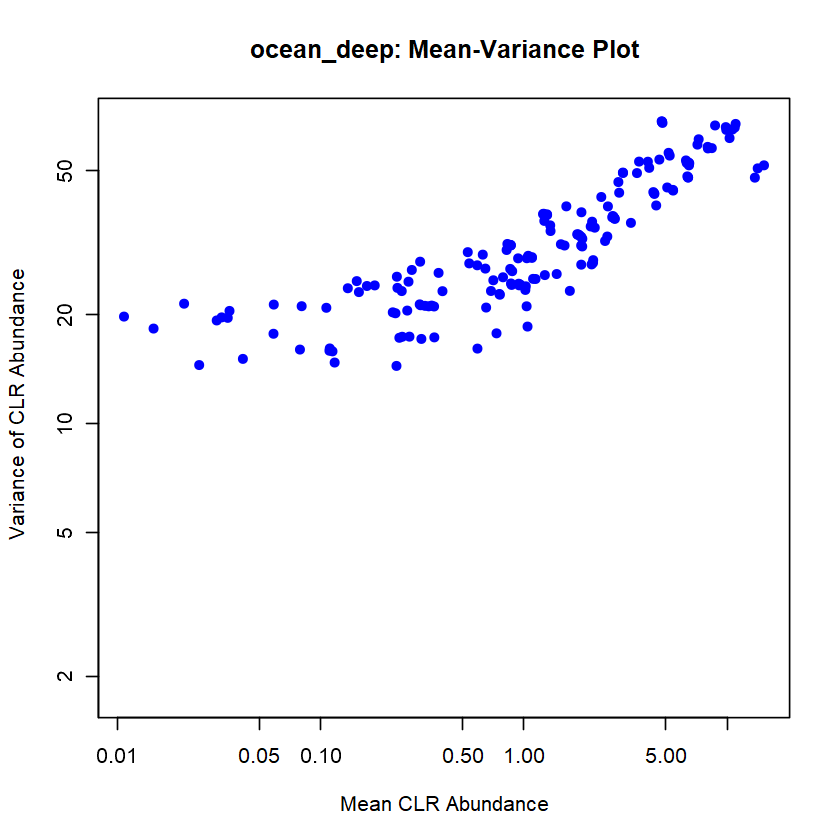

Running ALDEx2 CLR on: ocean_coastal

conditions vector supplied

operating in serial mode

removed rows with sums equal to zero

computing center with all features

data format is OK

dirichlet samples complete

transformation complete



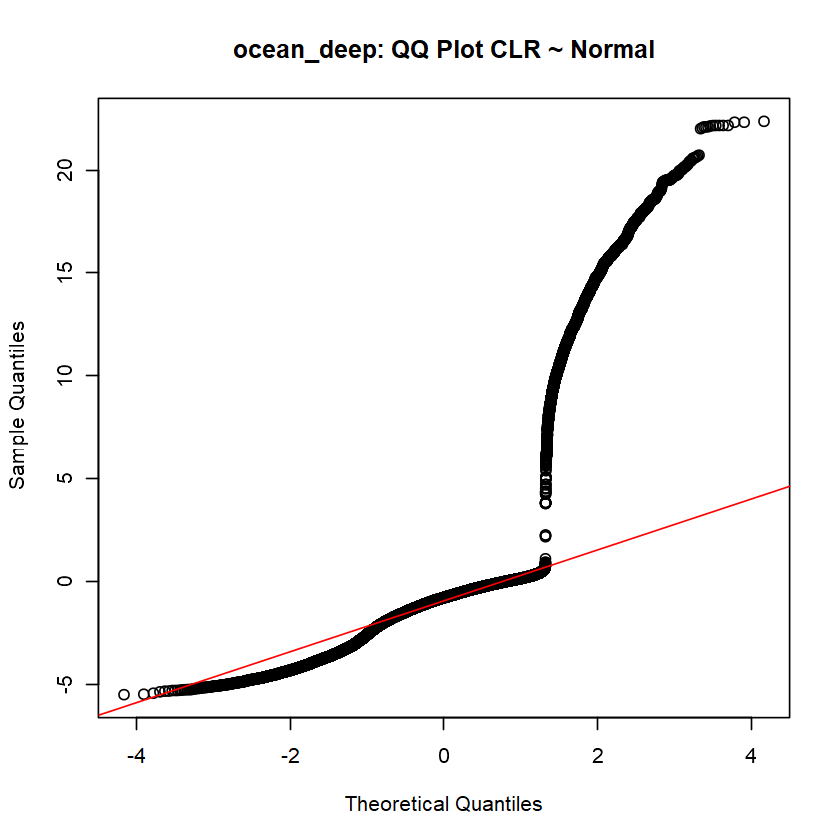

Warning message in xy.coords(x, y, xlabel, ylabel, log):
"149 x values <= 0 omitted from logarithmic plot"


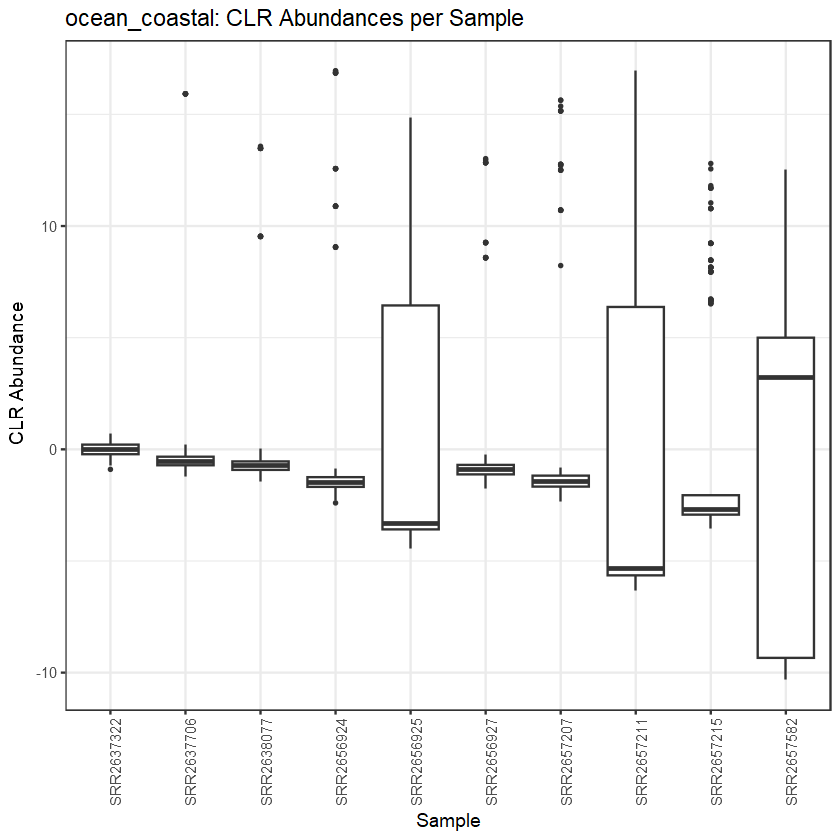

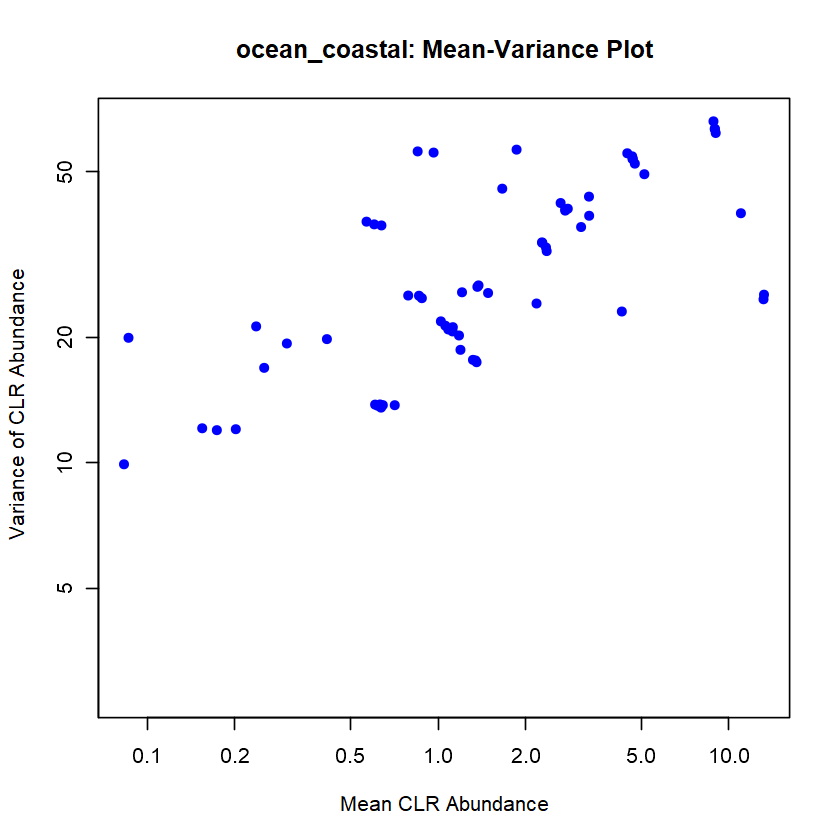

Running ALDEx2 CLR on: ocean_coastal_amp

conditions vector supplied

operating in serial mode

removed rows with sums equal to zero

computing center with all features

data format is OK

dirichlet samples complete

transformation complete



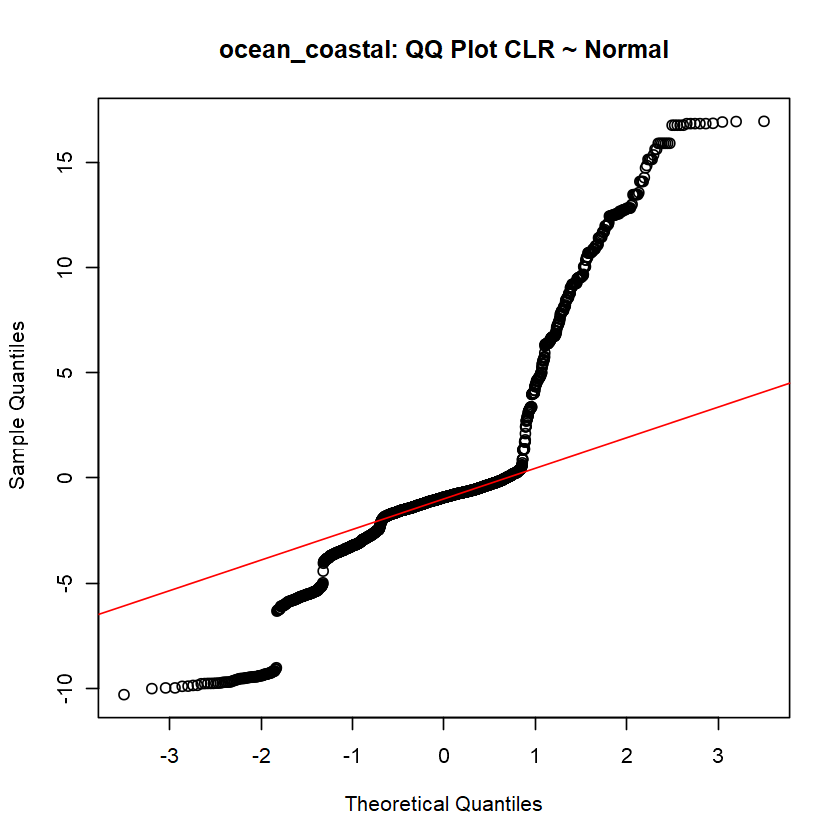

Warning message in xy.coords(x, y, xlabel, ylabel, log):
"1489 x values <= 0 omitted from logarithmic plot"


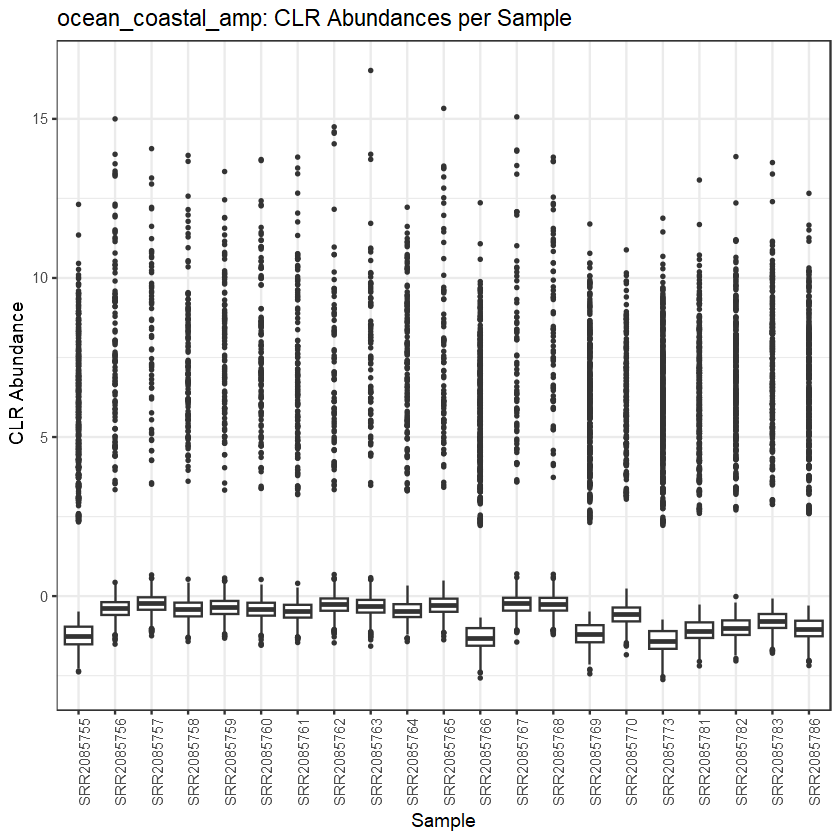

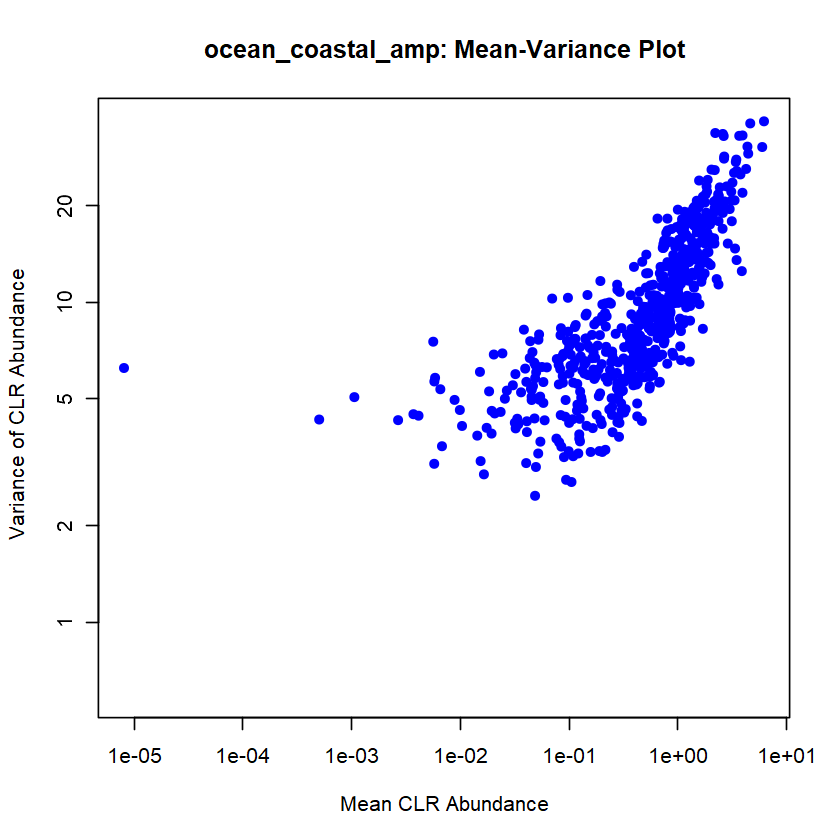

Running ALDEx2 CLR on: hetero_amp

conditions vector supplied

operating in serial mode

removed rows with sums equal to zero

computing center with all features

data format is OK

dirichlet samples complete

transformation complete



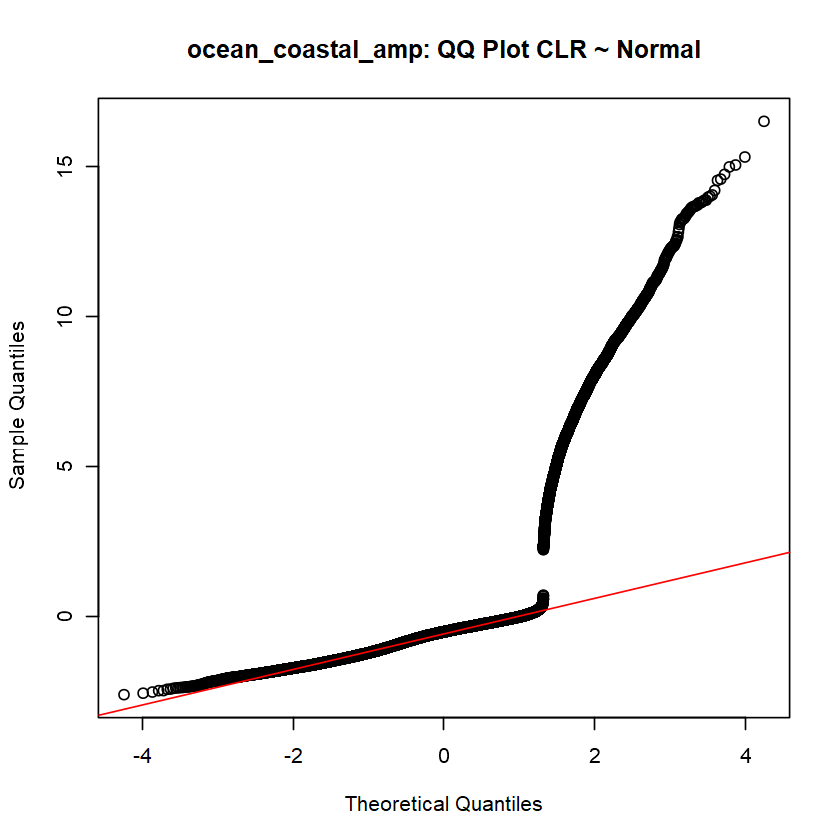

Warning message in xy.coords(x, y, xlabel, ylabel, log):
"3864 x values <= 0 omitted from logarithmic plot"


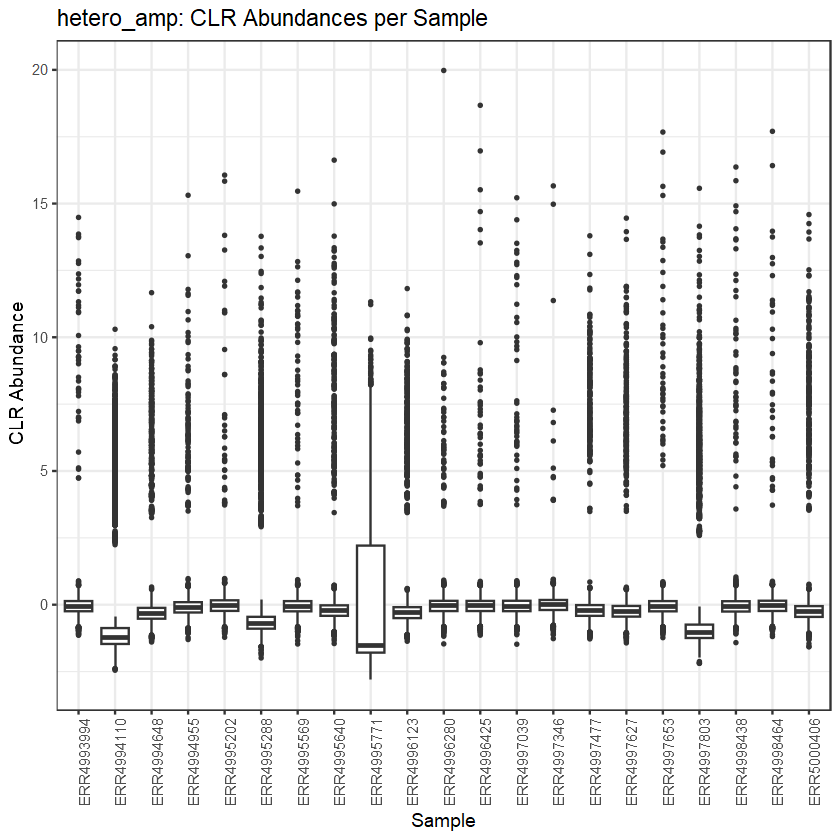

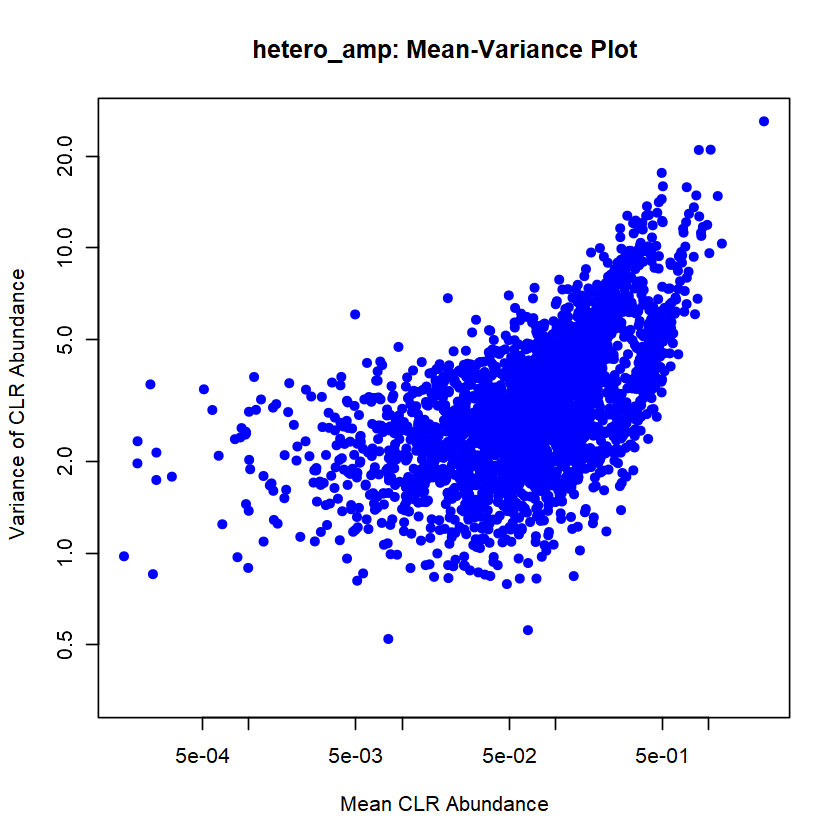

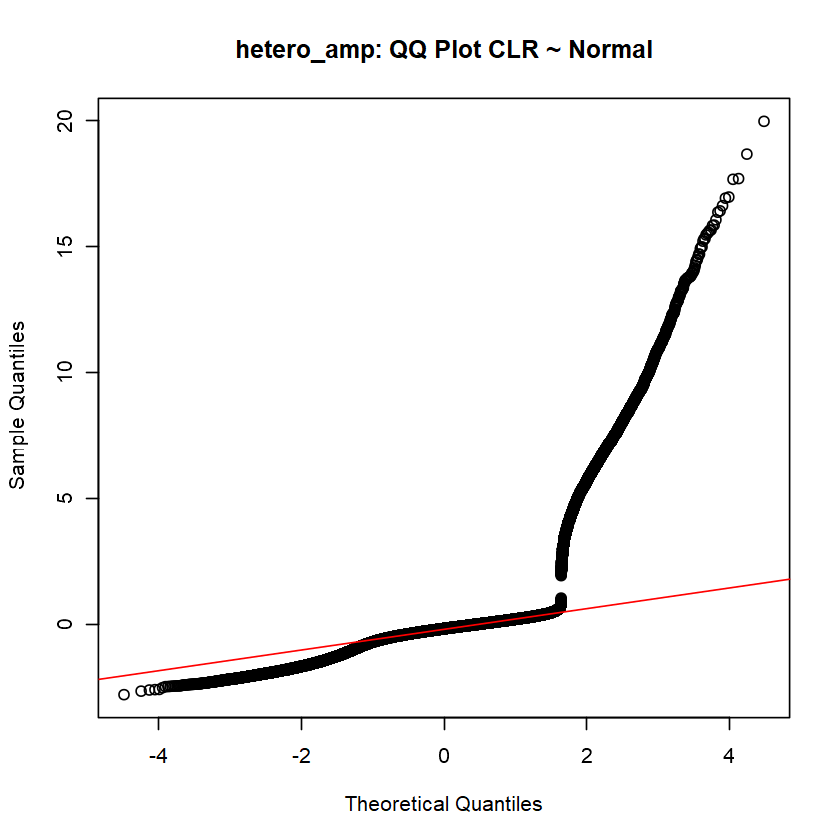

In [11]:
run_aldex_normalization <- function(abundance, cond_label, seed = 42) {
  set.seed(seed)
  abundance[is.na(abundance)] <- 0
  abundance <- abundance[rowSums(abundance) > 0, , drop = FALSE]
  
  if (any(duplicated(colnames(abundance)))) {
    warning("Duplicate sample names found. Making them unique.")
    colnames(abundance) <- make.unique(colnames(abundance))
  }
  
  conds <- rep("heterogenic", ncol(abundance))
  aldex_clr <- aldex.clr(abundance, conds = conds, mc.samples = 128, denom = "all", verbose = TRUE)
  clr_list <- aldex_clr@analysisData
  clr_avg <- lapply(clr_list, function(mat) rowMeans(mat))
  clr_matrix <- do.call(cbind, clr_avg)
  colnames(clr_matrix) <- colnames(abundance)
  rownames(clr_matrix) <- rownames(abundance)
  return(clr_matrix)
}

# 2. Visualization wrapper function
plot_clr_diagnostics <- function(clr_matrix, title_prefix = "") {
  # Boxplot per sample
  clr_long <- melt(clr_matrix, varnames = c("Feature", "Sample"), value.name = "CLR_Value")
  p1 <- ggplot(clr_long, aes(x = Sample, y = CLR_Value)) +
    geom_boxplot(outlier.size = 0.5) +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    labs(title = paste0(title_prefix, ": CLR Abundances per Sample"),
         y = "CLR Abundance", x = "Sample")
  print(p1)
  
  # Mean-variance plot
  clr_means <- rowMeans(clr_matrix)
  clr_vars  <- apply(clr_matrix, 1, var)
  plot(clr_means, clr_vars, log = "xy", pch = 16, col = "blue",
       main = paste0(title_prefix, ": Mean-Variance Plot"),
       xlab = "Mean CLR Abundance", ylab = "Variance of CLR Abundance")
  
  # QQ plot
  qqnorm(as.vector(clr_matrix), main = paste0(title_prefix, ": QQ Plot CLR ~ Normal"))
  qqline(as.vector(clr_matrix), col = "red")
}

# 3. Define input list
abundance_list <- list(
  ocean_deep         = taxa_od_wgs,
  ocean_coastal      = taxa_oc_wgs,
  ocean_coastal_amp  = tax_abund_oc,
  hetero_amp         = tax_abund_hetero
)

# 4. Normalize and visualize each
clr_results <- list()

for (cond in names(abundance_list)) {
  message("Running ALDEx2 CLR on: ", cond)
  clr_mat <- run_aldex_normalization(abundance_list[[cond]], cond)
  clr_results[[cond]] <- clr_mat
  
  # Plotting
  plot_clr_diagnostics(clr_mat, title_prefix = cond)
}


In [12]:
plot_clr_boxplot <- function(clr_matrix, title_prefix = "") {
  clr_long <- melt(clr_matrix, varnames = c("Feature", "Sample"), value.name = "CLR_Value")
  p <- ggplot(clr_long, aes(x = Sample, y = CLR_Value)) +
    geom_boxplot(outlier.size = 0.5) +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    labs(title = paste0(title_prefix, ": CLR Abundances per Sample"),
         y = "CLR Abundance", x = "Sample")
  return(p)
}


# === Mean-Variance Plot ===
plot_clr_mean_variance <- function(clr_matrix, title_prefix = "") {
  clr_means <- rowMeans(clr_matrix)
  clr_vars  <- apply(clr_matrix, 1, var)
  p <- ggplot(data.frame(mean = clr_means, var = clr_vars), aes(x = mean, y = var)) +
    geom_point(color = "blue", size = 1) +
    scale_x_log10() + scale_y_log10() +
    theme_bw() +
    labs(title = paste0(title_prefix, ": Mean-Variance Plot"),
         x = "Mean CLR Abundance", y = "Variance")
  return(p)
}

# === QQ Plot Function ===
plot_clr_qqplot <- function(clr_matrix, title_prefix = "") {
  v <- as.vector(clr_matrix)
  df <- data.frame(sample = sort(v), theoretical = qqnorm(v, plot.it = FALSE)$x)
  p <- ggplot(df, aes(sample = sample)) +
    stat_qq() + stat_qq_line(col = "red") +
    theme_bw() +
    labs(title = paste0(title_prefix, ": QQ Plot CLR ~ Normal"),
         x = "Theoretical Quantiles", y = "Sample Quantiles")
  return(p)
}
plot_clr_qqplot_poisson <- function(clr_matrix, title_prefix = "") {
  v <- as.vector(clr_matrix)
  v <- v[!is.na(v)]  # remove NAs if any
  
  # Estimate λ from the data
  lambda <- mean(v[v > 0])  # use only positive values for Poisson
  
  # Compute theoretical quantiles from Poisson
  n <- length(v)
  probs <- ppoints(n)
  theoretical <- qpois(probs, lambda = lambda)
  
  # Build dataframe
  df <- data.frame(
    sample = sort(v),
    theoretical = sort(theoretical)
  )
  
  # Plot
  p <- ggplot(df, aes(x = theoretical, y = sample)) +
    geom_point(size = 1) +
    geom_abline(slope = 1, intercept = 0, color = "red") +
    theme_bw() +
    labs(title = paste0(title_prefix, ": QQ Plot CLR ~ Poisson(λ = ", round(lambda, 2), ")"),
         x = "Theoretical Quantiles (Poisson)", y = "Sample Quantiles (CLR)")
  
  return(p)
}

In [13]:
plot_samplewise_mv <- function(clr_matrix, n = 10, seed = 123, title = "") {
  set.seed(seed)
  samples <- sample(colnames(clr_matrix), min(n, ncol(clr_matrix)))
  
  mv_df <- data.frame()
  for (sample in samples) {
    sample_vec <- clr_matrix[, sample]
    mv_df <- rbind(mv_df,
                   data.frame(
                     Sample = sample,
                     Mean = mean(sample_vec),
                     Variance = var(sample_vec)
                   ))
  }
  
  ggplot(mv_df, aes(x = Mean, y = Variance, color = Sample)) +
    geom_point(size = 3) +
    theme_minimal() +
    labs(title = title, x = "Mean CLR Abundance", y = "Variance") +
    scale_color_discrete(name = "Sample")
}

# Subsampled for 10 samples in each environment 

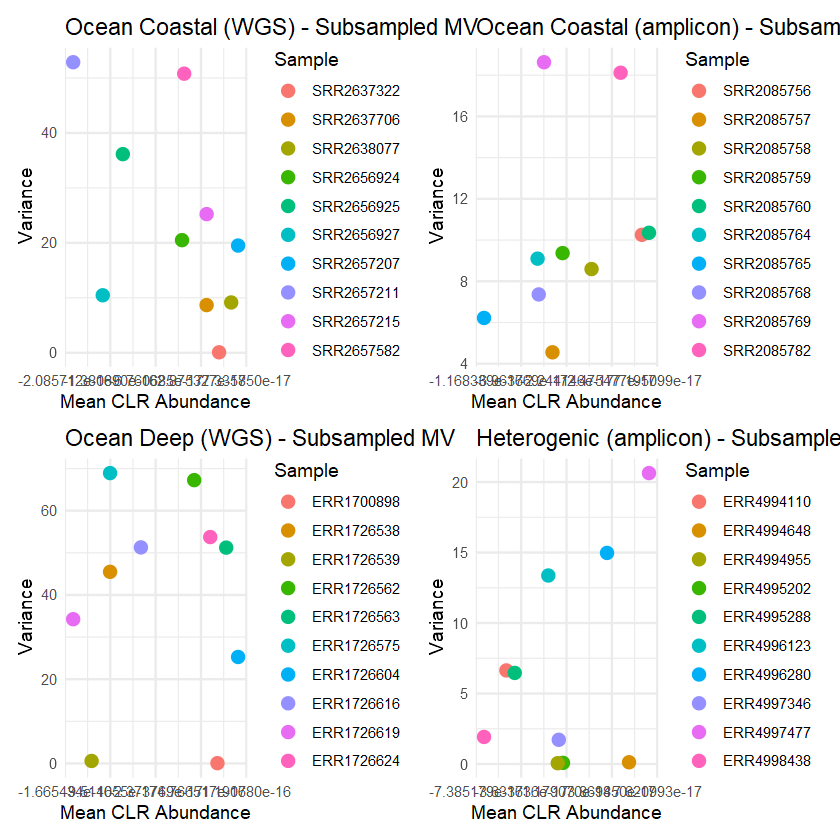

In [ ]:
wrap_plots( plot_samplewise_mv(clr_oc_wgs_filtered, title = "Ocean Coastal (WGS) - Subsampled MV"),
            plot_samplewise_mv(clr_oc_amp_filtered , title = "Ocean Coastal (amplicon) - Subsampled MV"),
            plot_samplewise_mv(clr_od_wgs_filtered , title = "Ocean Deep (WGS) - Subsampled MV"),
            plot_samplewise_mv(clr_hetero_amp_filtered, title = "Heterogenic (amplicon) - Subsampled MV"),
            ncol = 2, nrow = 2)


# Q-Q plots for all distributions

In [ ]:
plot_all_distributions <- function(clr_matrix, title_prefix = "") {
  v <- as.vector(clr_matrix)
  v <- v[!is.na(v)]
  v_pos <- v[v > 0] 
  
  n <- length(v_pos)
  probs <- ppoints(n)
  
  plots <- list()

  # === QQ Normal ===
  plots[["Normal"]] <- ggplot(data.frame(sample = sort(v_pos),
                                         theoretical = qqnorm(v_pos, plot.it = FALSE)$x),
                              aes(sample = sample)) +
    stat_qq() + stat_qq_line(col = "red") +
    theme_bw() +
    labs(title = paste0(title_prefix, ": Normal"),
         x = "Theoretical Quantiles", y = "Sample Quantiles")

  # === QQ Poisson ===
  lambda <- mean(v_pos)
  theo_pois <- qpois(probs, lambda)
  plots[["Poisson"]] <- ggplot(data.frame(sample = sort(v_pos), theoretical = sort(theo_pois)),
                               aes(x = theoretical, y = sample)) +
    geom_point(size = 1) +
    geom_abline(slope = 1, intercept = 0, col = "red") +
    theme_bw() +
    labs(title = paste0(title_prefix, ": Poisson(λ=", round(lambda,2), ")"),
         x = "Theoretical Quantiles", y = "Sample Quantiles")

  # === QQ Log-Normal ===
  log_v <- log(v_pos)
  plots[["LogNormal"]] <- ggplot(data.frame(sample = sort(log_v),
                                            theoretical = qqnorm(log_v, plot.it = FALSE)$x),
                                 aes(sample = sample)) +
    stat_qq() + stat_qq_line(col = "red") +
    theme_bw() +
    labs(title = paste0(title_prefix, ": Log-Normal"),
         x = "Theoretical Quantiles", y = "Log Sample Quantiles")

  # === QQ Negative Binomial ===
  nb_fit <- tryCatch({
    fitdistr(round(v_pos), "Negative Binomial")
  }, error = function(e) NULL)
  
  if (!is.null(nb_fit)) {
    size <- nb_fit$estimate["size"]
    mu <- nb_fit$estimate["mu"]
    theo_nb <- qnbinom(probs, size = size, mu = mu)
    plots[["NegBinom"]] <- ggplot(data.frame(sample = sort(v_pos), theoretical = sort(theo_nb)),
                                  aes(x = theoretical, y = sample)) +
      geom_point(size = 1) +
      geom_abline(slope = 1, intercept = 0, col = "red") +
      theme_bw() +
      labs(title = paste0(title_prefix, ": NegBinom(mu=", round(mu,1), ", size=", round(size,1), ")"),
           x = "Theoretical Quantiles", y = "Sample Quantiles")
  }

  # === QQ Gamma ===
  shape <- mean(v_pos)^2 / var(v_pos)
  rate <- mean(v_pos) / var(v_pos)
  theo_gamma <- qgamma(probs, shape = shape, rate = rate)
  plots[["Gamma"]] <- ggplot(data.frame(sample = sort(v_pos), theoretical = sort(theo_gamma)),
                             aes(x = theoretical, y = sample)) +
    geom_point(size = 1) +
    geom_abline(slope = 1, intercept = 0, col = "red") +
    theme_bw() +
    labs(title = paste0(title_prefix, ": Gamma"),
         x = "Theoretical Quantiles", y = "Sample Quantiles")

  # === QQ Log-Cauchy ===
  cauchy_fit <- tryCatch({
    fitdist(log_v, "cauchy")
  }, error = function(e) NULL)
  
  if (!is.null(cauchy_fit)) {
    location <- cauchy_fit$estimate["location"]
    scale <- cauchy_fit$estimate["scale"]
    theo_lc <- qcauchy(probs, location, scale)
    plots[["Log-Cauchy"]] <- ggplot(data.frame(sample = sort(log_v), theoretical = sort(theo_lc)),
                                    aes(x = theoretical, y = sample)) +
      geom_point(size = 1) +
      geom_abline(slope = 1, intercept = 0, col = "red") +
      theme_bw() +
      labs(title = paste0(title_prefix, ": Log-Cauchy"),
           x = "Theoretical Quantiles", y = "Log Sample Quantiles")
  }

  # === QQ Weibull ===
  weibull_fit <- tryCatch({
    fitdist(v_pos, "weibull")
  }, error = function(e) NULL)

  if (!is.null(weibull_fit)) {
    shape_w <- weibull_fit$estimate["shape"]
    scale_w <- weibull_fit$estimate["scale"]
    theo_weibull <- qweibull(probs, shape = shape_w, scale = scale_w)
    plots[["Weibull"]] <- ggplot(data.frame(sample = sort(v_pos), theoretical = sort(theo_weibull)),
                                 aes(x = theoretical, y = sample)) +
      geom_point(size = 1) +
      geom_abline(slope = 1, intercept = 0, col = "red") +
      theme_bw() +
      labs(title = paste0(title_prefix, ": Weibull"),
           x = "Theoretical Quantiles", y = "Sample Quantiles")
  }

  
  wrap_plots(plots, ncol = 3, nrow = 3)
}

Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'Ocean Deep (WGS): Poisson(λ=6.92)' in 'mbcsToSbcs': dot substituted for <ce>"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'Ocean Deep (WGS): Poisson(λ=6.92)' in 'mbcsToSbcs': dot substituted for <bb>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'Ocean Deep (WGS): Poisson(λ=6.92)' in 'mbcsToSbcs': dot substituted for <ce>"
Warning message in grid.C

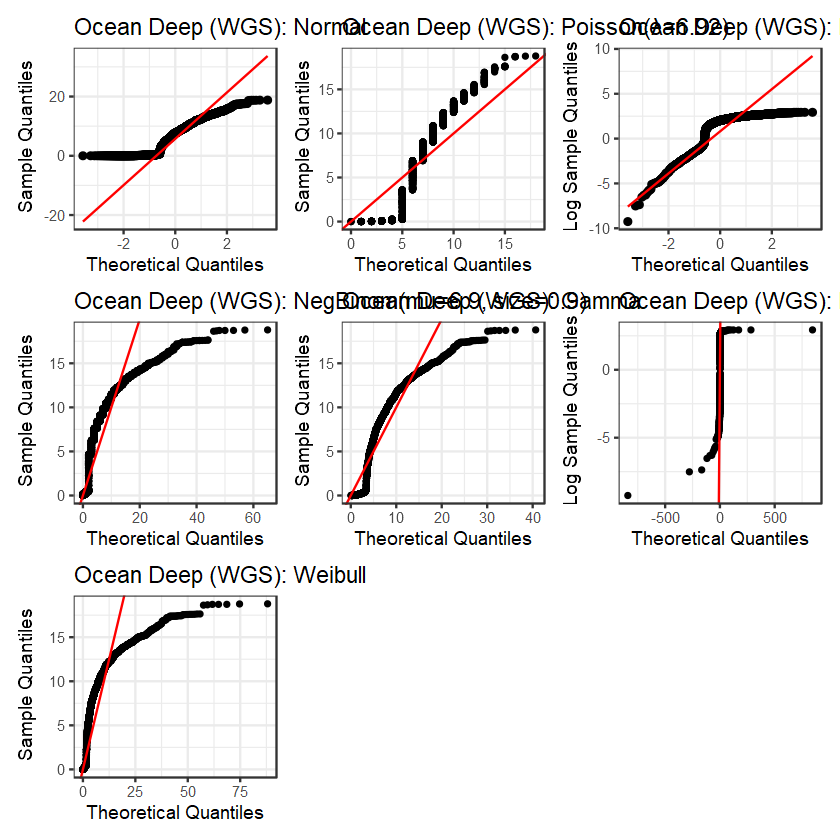

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'Ocean Coastal (Amplicon): Poisson(λ=5.79)' in 'mbcsToSbcs': dot substituted for <ce>"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'Ocean Coastal (Amplicon): Poisson(λ=5.79)' in 'mbcsToSbcs': dot substituted for <bb>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'Ocean Coastal (Amplicon): Poisson(λ=5.79)' in 'mbcsToSbcs': dot substituted for <ce>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'Ocean Coastal (Amplicon): Poisson(λ=5.79)' in 'mbcsToSbcs': dot substituted for <bb>"


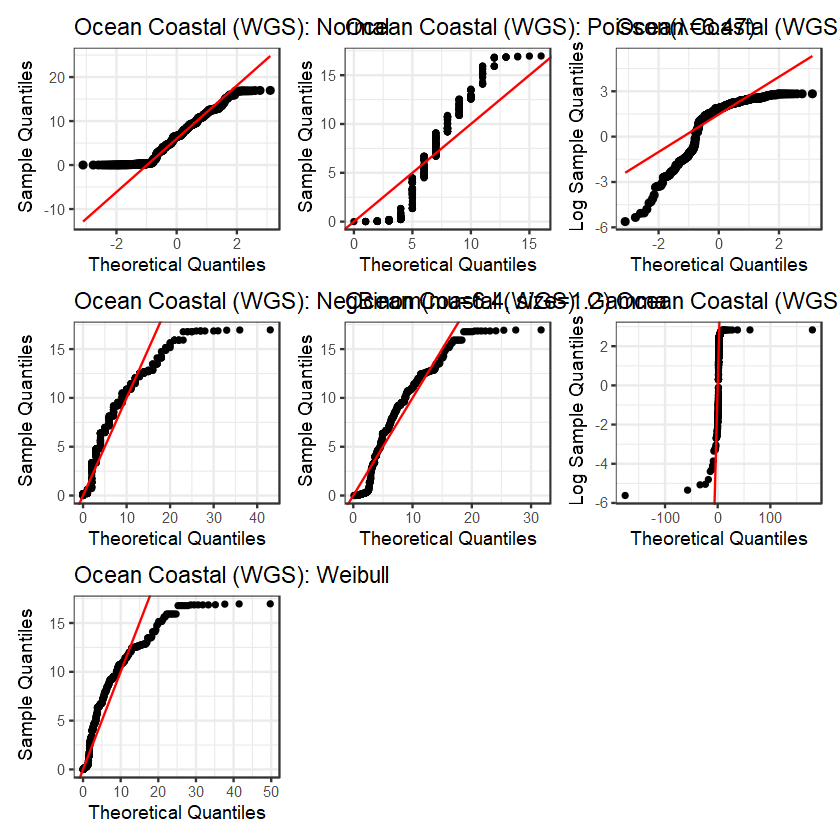

Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'Hetero (Amplicon): Poisson(λ=2.79)' in 'mbcsToSbcs': dot substituted for <ce>"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'Hetero (Amplicon): Poisson(λ=2.79)' in 'mbcsToSbcs': dot substituted for <bb>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'Hetero (Amplicon): Poisson(λ=2.79)' in 'mbcsToSbcs': dot substituted for <ce>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'Hetero (Amplicon): Poisson(λ=2.79)' in 'mbcsToSbcs': dot substituted for <bb>"


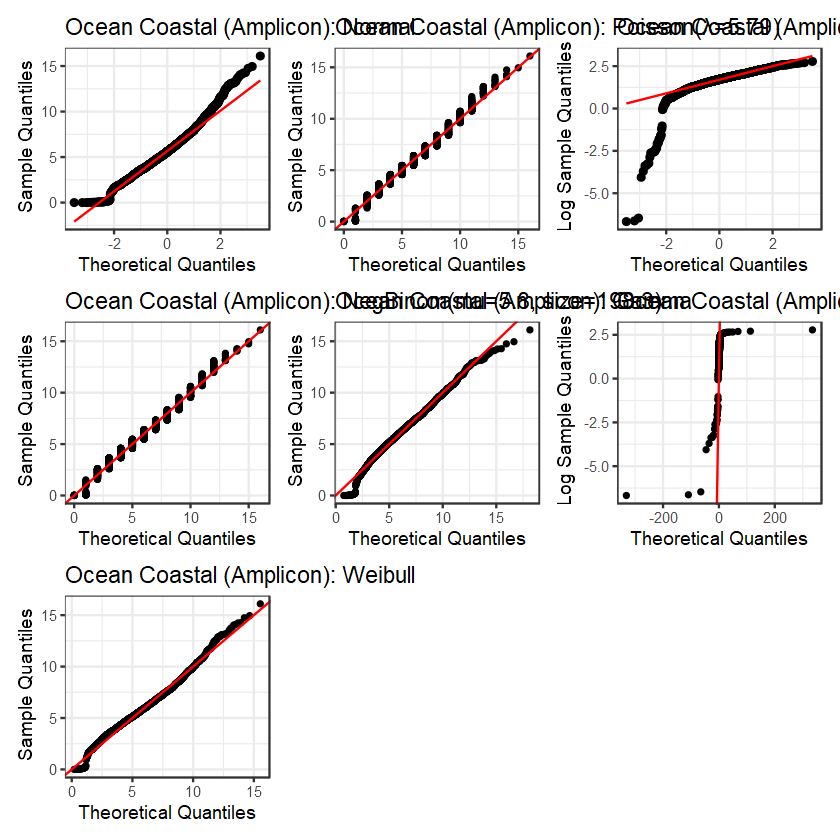

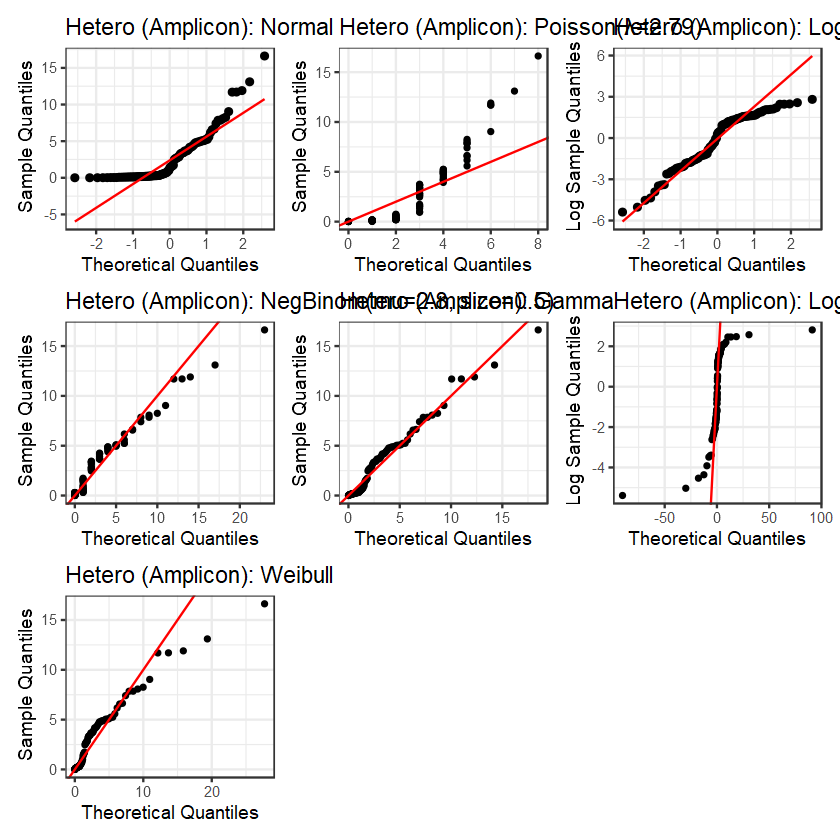

In [16]:
plot_all_distributions(clr_od_wgs_filtered, "Ocean Deep (WGS)")
plot_all_distributions(clr_oc_wgs_filtered, "Ocean Coastal (WGS)")
plot_all_distributions(clr_oc_amp_filtered, "Ocean Coastal (Amplicon)")
plot_all_distributions(clr_hetero_amp_filtered, "Hetero (Amplicon)")